# Grandata - DE Test - Consigna

El dataset eventos.csv.gz refleja las interaciones entre los usuarios de un servicio de comunicaciones. Cada registro muestra los eventos ocurridos durante una hora entera entre un par de usuarios (origen y destino).
Columna

Descripción

● id_source: ID del usuario origen (el que inicia los eventos)

● id_destination: ID del usuario destino

● region: Región del país donde se registaron los eventos

● date: Fecha (YYYYMMDD)

● hour: Hora del día (0, ..., 23)

● calls: Cantidad de llamadas entre los usuarios durante esa hora

● seconds: Cantidad total de segundos que duraron las llamadas realizadas durante esa hora (0 si calls=0)

● sms: Cantidad de sms entre los usuarios durante esa hora

Ejemplo: si el día 20/01/2021 entre las 16:00 y las 16:59 hs
1. el ID A realizó 2 llamadas de 10 segundos cada una al ID B 2. elIDBenvió3smsalIDA
Entonces en el dataset de eventos se observarán los siguientes registros:
1. id_source=A, id_destination=B, date=20210120, hour=16, calls=2, seconds=20,
sms=0, ...
2. id_source=B, id_destination=A, date=20210120, hour=16, calls=0, seconds=0,
sms=3, ...

Aquellos registros con id_source o id_destination nulo deben ser descartados.

El dataset free_sms_destinations.csv.gz contiene los ID de los usuarios hacia quienes se puede enviar sms de manera gratuita (destinos gratuitos).

Los sms se facturan siempre al usuario origen, de la siguiente manera:

● $0.0 si el destino es gratuito

● $1.5 si el evento se registra en las regiones 1 a 5

● $2.0 si el evento se registra en las regiones 6 a 9

Se pide:
1. Calcular el monto total que facturará el proveedor del servicio por envíos de sms.
2. Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip.
3. Graficar un histograma de cantidad de llamadas que se realizan por hora del día.


### Preparo los datos
- Leo archivos events.csv.gz y free_sms_destinations.csv.gz 
- Filtro las filas que no tiene id's nulos
- Joineo ambos datasets usando id_destination(events) y id(free_sms_destinations)
- Calculo el monto a facturar parcial por hora (valor del sms * cantidad de sms)
    - valor del sms: 
        - si id(free_sms_destinations) no es null -> 0 
        - si 1 <= region <= 5 -> 1,5
        - sino -> 2Calculate the sms rate

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Init Spark
spark = SparkSession.builder.appName("GranData_DE_test").getOrCreate()

# Read events file
df_events = spark.read.csv("events.csv.gz", header=True, inferSchema=True)

# Filter rows with null id_source or id_destination
df_events = df_events.filter("id_source is not null and id_destination is not null")

# Read free_sms_destinations file
df_free_sms_destinations = spark.read.csv("free_sms_destinations.csv.gz", header=True, inferSchema=True)

# Join dataframe events with free_sms_destinations
df_events = df_events.join(df_free_sms_destinations, df_events["id_destination"] == df_free_sms_destinations["id"], "left_outer")

# Calculate the sms rate and partial_amount
df_events = df_events.withColumn("sms_rate", 
                                   F.when(df_events["id"].isNotNull(), 0.0)
                                   .when((df_events["region"] >= 1) & (df_events["region"] <= 5), 1.5)
                                   .otherwise(2.0)
                                  )
df_events = df_events.withColumn("partial_amount",df_events["sms_rate"]*df_events["sms"])

## 1. Calcular el monto total que facturará el proveedor del servicio por envíos de sms.


In [2]:
total_amount = df_events.groupBy().sum("partial_amount").collect()[0][0]
print("Total amount of sms: ", total_amount)

Total amount of sms:  391367.0


## 2. Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. 

## Además del ID, incluir el ID hasheado mediante el algoritmo MD5. 

## Escribir el dataset en formato parquet con compresión gzip.


In [3]:
# Generar un dataset con los 100 usuarios con mayor facturación
top_100_users = df_events.groupBy("id_source").sum("partial_amount").sort("sum(partial_amount)", ascending=False).limit(100)
top_100_users = top_100_users.withColumn("id_md5", F.expr("MD5(id_source)"))
top_100_users.write.parquet("events.parquet.gz", compression="gzip", mode='overwrite')

In [4]:
top_100_users.show()

+---------+-------------------+--------------------+
|id_source|sum(partial_amount)|              id_md5|
+---------+-------------------+--------------------+
|      4D3|            23403.0|911914c7729eedbdf...|
|      76D|            13664.0|bd180b7811395cbce...|
|      07E|             4226.0|14a0660ae2f5d1868...|
|      541|             2526.0|16c222aa19898e505...|
|      C25|             2019.0|0bfa0b57d99985aa1...|
|      17D|             1209.0|7521526054bb89ba2...|
|      3AE|             1087.5|6a57072949dbc409c...|
|      B86|             1054.5|bc97b32ee2abb9c18...|
|      E89|              979.5|5135cc35322269f2f...|
|      B71|              972.0|1088a10d026eae0ac...|
|      162|              887.5|82aa4b0af34c2313a...|
|      068|              854.5|fb8490a9504a36c21...|
|      A2C|              691.5|d7dcc6703e425a6e3...|
|      335|              681.0|f9b902fc3289af4dd...|
|      1BD|              679.0|f5a45e33602ea62f9...|
|      3E0|              661.5|e9d076deb3451cc

## 3. Graficar un histograma de cantidad de llamadas que se realizan por hora del día.


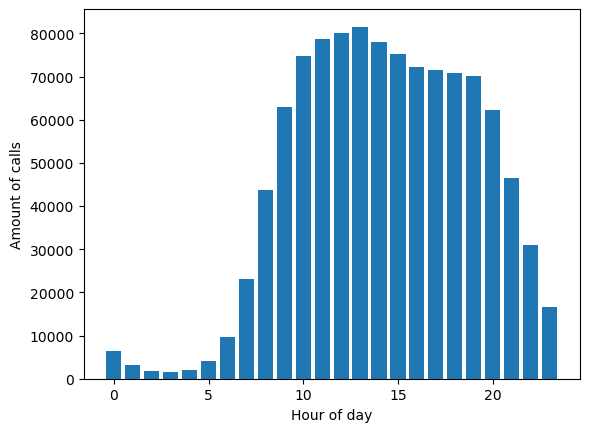

In [5]:
from matplotlib import pyplot as plt

# Agrupar los datos por hora
df_calls_per_hour = df_events.groupBy("hour").sum("calls").sort("hour")

# Obtener los datos para graficar
hours = df_calls_per_hour.rdd.map(lambda x: x[0]).collect() 
amount_calls = df_calls_per_hour.rdd.map(lambda x: x[1]).collect()

# Graficar el histograma
plt.bar(hours, amount_calls)
plt.xlabel("Hour of day")
plt.ylabel("Amount of calls")
plt.show()